In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
abatement = pd.read_csv('./Data/abatement_calculations.csv')
gdp = pd.read_excel('./Data/gdp_pc.xlsx')

In [4]:
gdp.set_index('Country Name', inplace=True)
abatement.set_index('country', inplace=True)
abatement.drop('Unnamed: 0', axis=1, inplace=True)

In [5]:
Countries = ['Belgium', 'France', 'Germany', 'Italy', 'Netherlands', 'Poland', 'Portugal','Romania',
'Spain','United Kingdom','Turkey','Sweden','Norway','Kazakhstan','Ukraine','Uzbekistan','Canada',
'United States','Argentina','Brazil','Chile','Colombia','Mexico','China','India','Indonesia',
'Japan','Malaysia','Thailand','Australia','New Zealand','Algeria','Nigeria','South Africa','Kuwait',
'Saudi Arabia','United Arab Emirates','World'
    ]

Countries.sort()
gdp = gdp.loc[gdp.index.isin(Countries)]

In [6]:
abatement_yoy_change = abatement.T.diff()
#abatement_yoy_change.drop('1990', inplace=True)

In [7]:
abatement_yoy_change.drop('1990', axis=0, inplace=True)
gdp.drop([1990, 2015, 2016, 2017], axis=1, inplace=True)

In [8]:
names =[]
for i in gdp.columns:
    i = str(i)
    names.append(i)
    
gdp.columns = names

In [9]:
gdp.isnull().sum().sum()

4

In [10]:
gdp.fillna(0, inplace=True)

In [11]:
clusters = pd.merge(abatement_yoy_change.T, gdp, how='inner',
                    left_index=True, right_index=True,
                   suffixes=['_abatement','_gdp_pc'])

In [12]:
clusters.shape

(38, 48)

In [13]:
clusters.head()

,1991_abatement,1992_abatement,1993_abatement,1994_abatement,1995_abatement,1996_abatement,1997_abatement,1998_abatement,1999_abatement,2000_abatement,...,2005_gdp_pc,2006_gdp_pc,2007_gdp_pc,2008_gdp_pc,2009_gdp_pc,2010_gdp_pc,2011_gdp_pc,2012_gdp_pc,2013_gdp_pc,2014_gdp_pc
Algeria,0.221591,-0.144035,0.193535,-0.257759,0.049240,-0.092277,-0.072547,0.164976,-0.010782,-0.187619,...,3100.122378,3464.610079,3935.183343,4905.254866,3868.831230,4463.394675,5432.413320,5565.134521,5471.123389,5466.425778
Argentina,-2.514651,4.366813,0.885648,2.289184,-1.163970,-4.532136,5.207687,-2.070757,-5.869402,6.050696,...,5076.883829,5878.761027,7193.617640,8953.359275,8161.306966,10276.260498,12726.908359,12969.707124,12976.636425,12245.256449
Australia,1.556081,-0.561085,1.067321,-0.742895,-0.534435,0.393304,1.492848,-0.665100,0.671673,-0.189580,...,33961.681802,36019.203051,40905.470894,49535.257874,42709.803303,51936.888712,62411.785447,67864.689862,67990.290030,62327.555939
Belgium,0.043625,0.054352,-0.053460,0.105818,0.039514,-0.036604,-0.038866,0.117332,-0.031643,0.138529,...,36967.259184,38852.372928,44403.766899,48424.575596,44880.573020,44380.176633,47702.811894,44740.583248,46582.669550,47351.974179
Brazil,9.756433,11.309725,107.584207,18.490205,-123.463794,-15.848677,8.902263,7.649689,-102.370462,6.281242,...,4770.183845,5860.145829,7313.557773,8787.610658,8553.381368,11224.154083,13167.472892,12291.466852,12216.904464,12026.619391


In [25]:
from sklearn.preprocessing import minmax_scale, StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [26]:
n = range(2,15, 1)

kmeans_inertia = []
kmeans_silhouette = []
for i in n:
    km = KMeans(n_clusters=i, random_state=1994)
    km.fit(clusters)
    predictions = km.predict(clusters)
    kmeans_inertia.append(km.inertia_)
    kmeans_silhouette.append(silhouette_score(clusters, predictions))

kmeans_silhouette = minmax_scale(kmeans_silhouette)
kmeans_inertia = minmax_scale(kmeans_inertia)

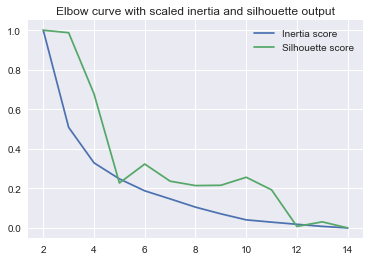

In [27]:
plt.plot(n, kmeans_inertia, label='Inertia score');
plt.plot(n, kmeans_silhouette, label='Silhouette score');
plt.legend();
plt.title('Elbow curve with scaled inertia and silhouette output');

In [28]:
ss = StandardScaler()
clusters_scaled = ss.fit_transform(clusters)

In [29]:
km = KMeans(n_clusters = 4, random_state=1994)

In [30]:
km.fit(clusters_scaled)
centers = km.cluster_centers_
clusters['label'] = km.labels_

In [31]:
len(clusters[clusters['label']==0]),\
len(clusters[clusters['label']==1]),\
len(clusters[clusters['label']==2]),\
len(clusters[clusters['label']==3])

(20, 1, 15, 2)

In [39]:
print([i for i in clusters[clusters['label']==1].index])

['Norway']


In [40]:
print([i for i in clusters[clusters['label']==3].index])

['China', 'World']


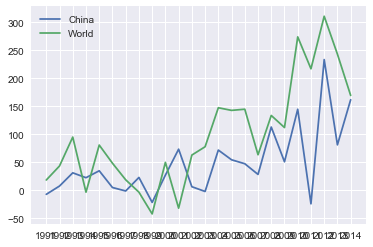

In [50]:
plt.plot(abatement_yoy_change['China'], label='China');
plt.plot(abatement_yoy_change['World'], label='World');
plt.legend();

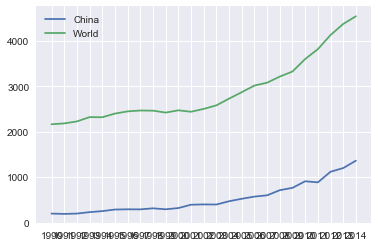

In [59]:
plt.plot(abatement.loc['China'], label='China');
plt.plot(abatement.loc['World'], label='World');
plt.legend();

In [63]:
emissions = pd.read_csv('./Data/C02_emissions.csv')
emissions.set_index('Country', inplace=True)
emissions.drop('Unnamed: 0', axis=1, inplace=True)

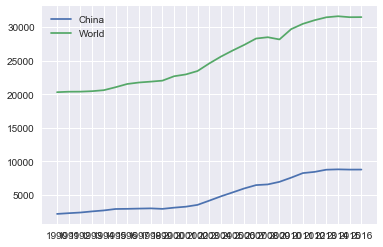

In [66]:
plt.plot(emissions.loc['China'], label='China');
plt.plot(emissions.loc['World'], label='World');
plt.legend();

In [ ]:
#Does this mean that other countries provide the basis of abatement
#but china is driving the increased change?

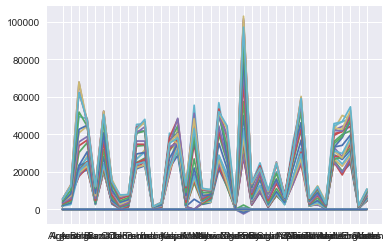

In [41]:
plt.plot(clusters)

In [46]:
clusters[clusters['label']==1]

,1991_abatement,1992_abatement,1993_abatement,1994_abatement,1995_abatement,1996_abatement,1997_abatement,1998_abatement,1999_abatement,2000_abatement,...,2006_gdp_pc,2007_gdp_pc,2008_gdp_pc,2009_gdp_pc,2010_gdp_pc,2011_gdp_pc,2012_gdp_pc,2013_gdp_pc,2014_gdp_pc,label
Norway,-49.527638,2315.4512,20.1682,-2431.127914,-242.297592,-1200.496694,890.258333,619.10823,-285.560418,468.76874,...,74114.69715,85170.862166,97007.941892,80067.176638,87770.266844,100711.224781,101668.170659,103059.248228,97199.919096,1


In [36]:
centers = pd.DataFrame(centers)

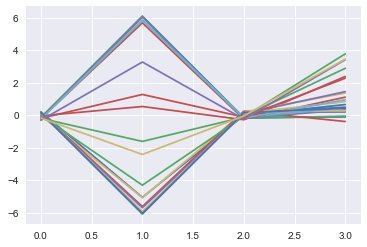

In [51]:
centers = pd.DataFrame(centers)
plt.plot(centers.iloc[:, 0:23]);
#useless graph, but fun to look at
#data art

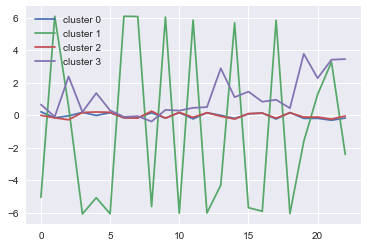

In [74]:
plt.plot(centers.iloc[0, 0:23], label='cluster 0');
plt.plot(centers.iloc[1, 0:23], label='cluster 1');
plt.plot(centers.iloc[2, 0:23], label='cluster 2');
plt.plot(centers.iloc[3, 0:23], label='cluster 3');
plt.legend()
plt.show()

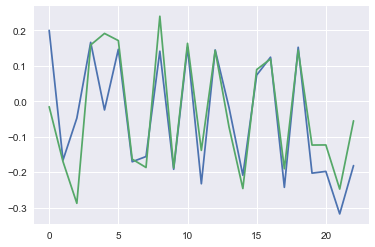

In [70]:
plt.plot(centers.iloc[0, 0:23]);
plt.plot(centers.iloc[2, 0:23]);

1. overall mean: mean of all datapoints used in cluster
2. sample means: means of each attribute included in cluster
3. ssb: (sample mean - overall mean ^2 )* n
4. MSB Final = ssb/(k-1) 
5. MSW Final = ssw or inertia/(n-k)
score = ssb/ssw

- try clustering with abatement notebook for yoy
- countries are rows, years are columns (include all years)
    - normalize all the data
    - use pctchange
- add in gdp pc
- use the labels to inform model groupings
- describe each group:
    - why are they in there?
    - who is the outlier?
    - who is the median?
   
   
- cluster represents abatement progress over time
 

In [21]:
km = KMeans(n_clusters=4, random_state=1994)

In [ ]:
km.fit(labels)

In [ ]:
km.cluster_centers_

In [222]:
abatement['labels'] = km.labels_

In [223]:
abatement['labels'].sort_values(ascending=True)

country
Canada                  0
United States           0
Algeria                 1
Ukraine                 1
Turkey                  1
Thailand                1
South Africa            1
Saudi Arabia            1
Romania                 1
Portugal                1
Poland                  1
Nigeria                 1
Malaysia                1
Kazakhstan              1
Mexico                  1
Uzbekistan              1
Indonesia               1
Argentina               1
Colombia                1
Chile                   1
United Kingdom          2
United Arab Emirates    2
Australia               2
Belgium                 2
Sweden                  2
Spain                   2
Italy                   2
France                  2
Germany                 2
New Zealand             2
Netherlands             2
Kuwait                  2
Japan                   2
China                   3
Norway                  4
Brazil                  5
India                   5
Name: labels, dtype: int32

To do:
- try to articulate descriptions for each cluster
    - were there certain times when there was a spike or drop
    - take each cluster and plot out abatement for all countries within that cluster
- look more into the attributes/commonalities within these disparaging groups

- consolidate this information into a presentation format
- final model to predict next 5 years (goal)

Variance analysis:
- build a table
- look at variance within clusters

In [47]:
labels = km.fit_predict(labels)

In [48]:
abatement['labels']= labels

In [50]:
abatement.head()

,country,co2_emissions,electric_emissions_pct,electric_production,reneg_production,co2_electricity,reneg_production_share,conventional_production_share,co2_units,co2_abated,labels
Unnamed: 0,,,,,,,,,,,
49,Algeria,133,38.83,71,0.28,51.6439,0.1988,70.8012,0.729421,0.145009,1
30,Argentina,198,38.04,142,31.69,75.3192,44.9998,97.0002,0.776485,34.941670,1
46,Australia,378,58.36,248,14.92,220.6008,37.0016,210.9984,1.045509,38.685519,7
6,Belgium,89,25.85,73,18.44,23.0065,13.4612,59.5388,0.386412,5.201568,0
31,Brazil,475,26.31,591,73.08,124.9725,431.9028,159.0972,0.785510,339.264127,5
